# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*Never let them guess your next move.*' has the following 3-grams:

* 'never let them'
* 'let them guess'
* 'them guess your'
* 'guess your next'
* 'your next move'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Manvir Kaur Singh</font>

E-mail: <font color="blue">manvir.kaur01@estudiant.upf.edu</font>

Date: <font color="blue">21/10/2023</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [2]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))
#print(messages)
#print(tweet)

Read 10000 documents


# 1. Auxiliary functions

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [3]:
def jaccard_similarity(a, b):
    set1 = set(a)
    set2 = set(b)
    intersection = set1.intersection(set2)
    union = set1.union(set2)

    if len(union) == 0:
        return 0.0
    else:
        return len(intersection) / len(union)

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [4]:
test_1_a = ['A', 'B', 'C']
test_1_b = ['B', 'C']
print(jaccard_similarity(test_1_a, test_1_b))

test_2_a = ['A', 'B', 'C', 'D']
test_2_b = ['A', 'B', 'C', 'B']
print(jaccard_similarity(test_2_a, test_2_b))

test_3_a = ['A', 'B', 'C']
test_3_b = ['A', 'B', 'C']
print(jaccard_similarity(test_3_a, test_3_b))

test_4_a = []
test_4_b = []
print(jaccard_similarity(test_4_a, test_4_b))

0.6666666666666666
0.75
1.0
0.0


In [5]:
print(len(messages))

10000


<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [6]:
def clean(text):
    text = re.sub(r'^RT ', '', text)
    text = text.lower()
    text = text.replace("ñ", "n").replace("ó", "o").replace("à", "a").replace("l·l", "ll").replace("è", "e")
    text = re.sub(r'https?://\S+', '', text)
    text = text.strip()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text

i added also that è should be replaced to e, because if not in some examples è is not being printed

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font> 


In [7]:
#Test your function by passing it five different texts including punctuation, non-Roman characters, URLs, etc. Make sure your test cases cover all the required aspects of the specification.
my_msg_1 = 'RT Caña, paral·lela, camión'
my_msg_2 = 'HOLA  HoLa'
my_msg_3 = 'https://www.google.com'
my_msg_4 = 'http://www.google.com'
my_msg_5 = '    my      function     @'

print(clean(my_msg_1))
print(clean(my_msg_2))
print(clean(my_msg_3))
print(clean(my_msg_4))
print(clean(my_msg_5))

cana parallela camion
hola hola


my function 


# 2. Implement an n-gram extractor

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [8]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    final_tokens = []
    ngrams = []
    for t in tokens:
        if len(t)>=MIN_TOKEN_LENGTH:
            final_tokens.append(t)
    for i in range(len(final_tokens) - size + 1):
        for j in range(i, i + size):
            my_elem = ' '.join(final_tokens[i:j+1])
        ngrams.append(my_elem)
    return ngrams


<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [9]:
print(messages[9780])
print(ngrams(messages[9780], 3))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants xinesos', 'comerciants xinesos donen', 'xinesos donen mascaretes', 'donen mascaretes gel', 'mascaretes gel antiseptic', 'gel antiseptic badalona', 'antiseptic badalona per', 'badalona per lluitar', 'per lluitar contra', 'lluitar contra coronavirus']


# 3. Estimation for brute force method

In [10]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to label the x and y axis.</font>

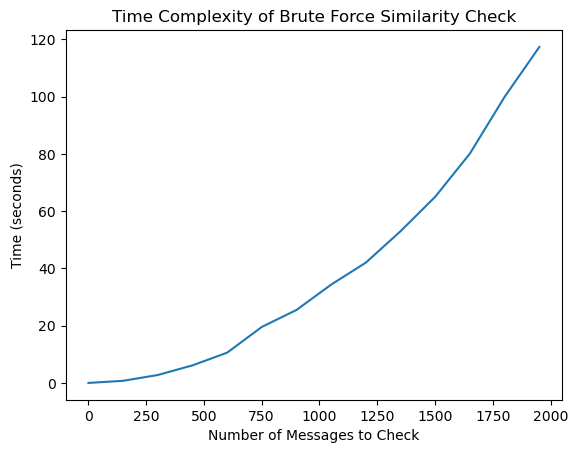

In [11]:
y = []
x = []
for i in range(1, 2002, 150):
    y.append(time_brute_force_similarities(messages, i, 4))
    x.append(i)
    
plt.plot(x,y)
plt.xlabel('Number of Messages to Check')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of Brute Force Similarity Check')
plt.show()

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>



1) I see an increasing slope, and between the range [800, 1250] number of messages to check looks like it increases rapidly first, up to 1000 and then it also increases up to 1250 but the slope seems to be smaller (it's an exponential)

2) There are 10000 messages as input, and in this plot we can see that it takes more or less  40 s to check 1000 messages and 120 s to check 2000 messages, so every 1000 messages to check it takes the double of the time.
so i can do 40*(2^0+2^1+2^2+2^3+2^4+2^5+2^6+2^7+2^8)=20440s which are 5.67 min and 0.0946 h

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [12]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        ngram_to_index[ngram] = next_index 
        index_to_ngram[next_index] = ngram

        next_index +=1
        
        

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 110568 distinct ngrams in the 10000 documents


In [13]:
print(ngram_to_index['els restaurants han reduir'])
print(ngram_to_index['supera fins tot mateix'])

45790
56854


 els restaurants han reduir    supera fins tot mateix
 
 Use these examples

<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [14]:
print(index_to_ngram[45696])
print(index_to_ngram[56737])

espanya supera italia velocitat
aquest tractament realment pugui


## 2.2 Create table ngrams x documents

In [15]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 110568 rows (distinct shingles) x 10000 columns (distinct documents)


<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [16]:
ngram_size = 4

for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)  
    for ngram in all_ngrams:
        ngram_index = ngram_to_index.get(ngram)
        if ngram_index is not None:  
            M_ngram_doc[ngram_index][docid] = True

print(M_ngram_doc)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False False  True]]


<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage.</font>

In [17]:
tot = M_ngram_doc.size

true_elem = np.count_nonzero(M_ngram_doc)

density_percentage = (true_elem / tot) * 100

print(density_percentage)

0.00999990955791911


<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [18]:

non_zero_indices = np.nonzero(M_ngram_doc[:, 9602])[0]

print("Positions of non-zeros in column of docid 9602 of M_ngram_doc\n")

# Clean message of the specified document
clean_message = clean(messages[9602])
print("Clean message:\n")
print(clean_message)

print("Non-zeros in corresponding row:")
my_arr = []
for i in non_zero_indices:
    print(i,index_to_ngram[i])


Positions of non-zeros in column of docid 9602 of M_ngram_doc

Clean message:

emergenciescat que puc fer i que no faqs del coronavirus a 14 de mar si us plau demanem difusio
Non-zeros in corresponding row:
110510 emergenciescat que puc fer
110511 que puc fer que
110512 puc fer que faqs
110513 fer que faqs del
110514 que faqs del coronavirus
110515 faqs del coronavirus mar
110516 del coronavirus mar plau
110517 coronavirus mar plau demanem
110518 mar plau demanem difusio


In [19]:
non_zero_indices = np.nonzero(M_ngram_doc[:, 941])[0]

print("Positions of non-zeros in column of docid 941 of M_ngram_doc\n")

# Clean message of the specified document
clean_message = clean(messages[941])
print("Clean message:\n")
print(clean_message)

print("Non-zeros in corresponding row:")
my_arr = []
for i in non_zero_indices:
    print(i,index_to_ngram[i])


Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean message:

hospiolot usem de forma responsable els recursos sanitaris 061 urgencies per coronavirus i sanitaries 012 consultes general
Non-zeros in corresponding row:
103660 hospiolot usem forma responsable
103671 sanitaries 012 consultes general
104120 els recursos sanitaris 061
104121 recursos sanitaris 061 urgencies
104122 sanitaris 061 urgencies per
105213 usem forma responsable els
105214 forma responsable els recursos
105215 responsable els recursos sanitaris
109004 061 urgencies per coronavirus
109005 urgencies per coronavirus sanitaries
109006 per coronavirus sanitaries 012
109007 coronavirus sanitaries 012 consultes


# 3. Implement a permutation generator

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [20]:
def random_permutation(k):
    my_list = list(range(k))
    random.shuffle(my_list)
    return my_list
        
#random_permutation(20)
        

In [21]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (test3)', '4 (test4)', '2 (test2)', '5 (test5)', '1 (test1)']
['3 (beta)', '4 (delta)', '2 (gamma)', '5 (epsilon)', '1 (alpha)']

Test another permutation
['1 (test1)', '2 (test2)', '5 (test5)', '3 (test3)', '4 (test4)']
['1 (alpha)', '2 (gamma)', '5 (epsilon)', '3 (beta)', '4 (delta)']


# 4. Compute the signature of each document

In [22]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 52870, 12701, 34005, ...
Permutation 1: 93888, 2764, 62576, ...
Permutation 2: 32799, 77603, 41360, ...
Permutation 3: 108398, 71121, 19559, ...
Permutation 4: 78403, 82068, 17023, ...


<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [23]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        first_ngram_id = find_first_one(docid, permutation)
        M_signature_doc[permutation_num, docid] = first_ngram_id

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [24]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge s clau
Ngrams        : [106908, 106909, 106910, 106911, 106912, 106913, 106914, 106915, 106916]
Signature     : [106910.0, 106914.0, 106915.0, 106914.0, 106911.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge s clau limitar la mobilitat ajudara a evitar la propagacio del coronavirus evitem de

# 5. Compare all pairs of signatures

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least 50 signature matches, considering both full matches and partial matches.</font>

In [25]:
is_possible_duplicate = {}
THRESHOLD = 50

# Iterate through all documents
for docid1 in range(len(messages)):
    
    #Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:
        
        #Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        #Extract the signature of doc1
        signature1 = M_signature_doc[:, docid1]

        #Iterate through documents with docid larger than doc1
        for docid2 in range(docid1 + 1, len(messages)):
            
            #If this has not already been marked as a duplicate of another document
            if docid2 not in is_possible_duplicate:
                
                #Extract signature of doc2
                signature2 = M_signature_doc[:, docid2]

                full_match = np.array_equal(signature1, signature2)

                if not full_match:
                    partial_match = np.sum(signature1 == signature2) > 0

                if full_match:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = docid1
                elif partial_match:
                    count_sig_partial_matches += 1

        #If the number of partial matches plus full matches exceeds the threshold, print the document doc1
        if count_sig_full_matches + count_sig_partial_matches >= THRESHOLD:
            print("Document %d has %d full matches and %d partial matches" % (docid1, count_sig_full_matches, count_sig_partial_matches))

Document 16 has 71 full matches and 18 partial matches
Document 19 has 11 full matches and 55 partial matches
Document 20 has 28 full matches and 23 partial matches
Document 42 has 21 full matches and 31 partial matches
Document 53 has 57 full matches and 0 partial matches
Document 73 has 16 full matches and 36 partial matches
Document 83 has 126 full matches and 0 partial matches
Document 166 has 56 full matches and 0 partial matches
Document 226 has 13 full matches and 46 partial matches
Document 328 has 65 full matches and 0 partial matches
Document 5077 has 176 full matches and 33 partial matches
Document 5109 has 66 full matches and 0 partial matches
Document 5117 has 71 full matches and 0 partial matches
Document 5129 has 54 full matches and 0 partial matches
Document 5271 has 54 full matches and 0 partial matches
Document 5636 has 80 full matches and 0 partial matches


<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

In [26]:
print_sig(messages, M_ngram_doc, M_signature_doc, 83 )

Document #83
Message       : RT @MainatJM: Imbècil total...
Clean message : mainatjm imbecil total
Ngrams        : []
Signature     : [-1.0, -1.0, -1.0, -1.0, -1.0]


The tweet "Document 83" with 126 full matches and 0 partial matches. This means that the this tweet is retweeted a lot of times or it is copied. This can be because its high popularity, or the need to stay within the Twitter's character limit, quoting the tweet while adding comments. The absence of partial matches implies minimal variation in the content when shared.


<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

In [27]:
print_sig(messages, M_ngram_doc, M_signature_doc, 77)

Document #77
Message       : RT @emergenciescat: ✅ Què puc fer i ⛔ què no si estic en una zona afectada pel confinament? 

#ProteccioCivil #Coronavirus https://t.co/lxz…
Clean message : emergenciescat que puc fer i que no si estic en una zona afectada pel confinament protecciocivil coronavirus
Ngrams        : [53479, 53480, 53481, 53482, 53483, 53484, 53485, 53486, 110510, 110511]
Signature     : [53486.0, 53481.0, 53480.0, 53481.0, 53484.0]


The high number of partial matches indicates that the tweet shares common phrases or keywords with many other documents in the dataset. However, the specific combination of these elements, along with potentially unique phrases or details mentioned in the tweet, makes it distinct enough to have only a few full matches. This suggests that while the tweet's general theme and context are found in other documents, the wording and additional information provided in Document 77 make it less common in its entirety.

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, compare what happens with 3 different ngram sizes (2-grams, 3-grams, 4-grams) in terms of the efficiency (speed) and effectiveness (accuracy). You can include plots for efficiency, and examples for effectiveness.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: various ngram sizes</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

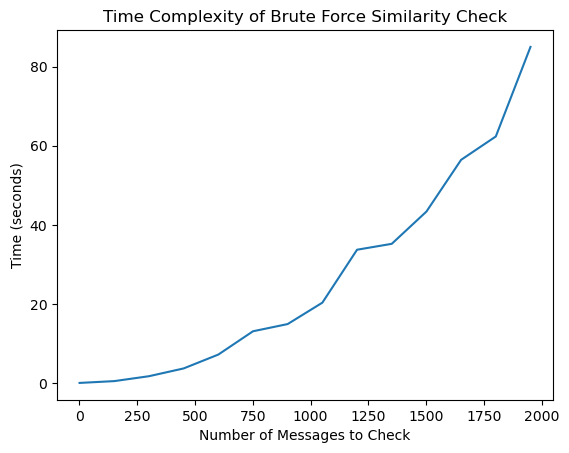

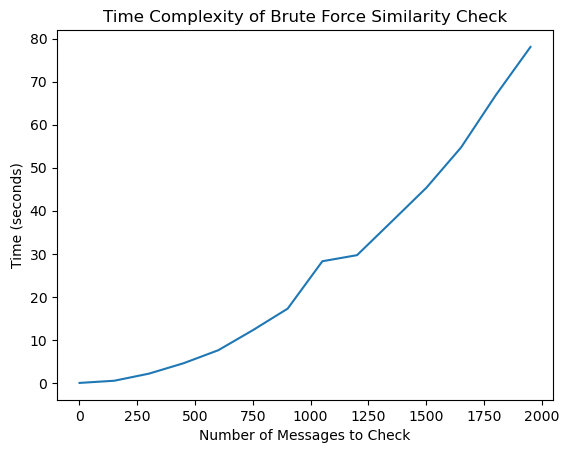

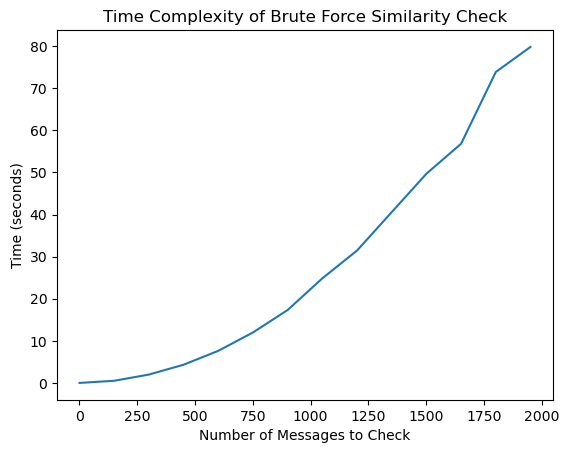

In [28]:
#EFFICIENCY (Speed) Comparison:
def efficiency_comp(messages, ngram_n):
    y = []
    x = []
    for i in range(1, 2002, 150):
        y.append(time_brute_force_similarities(messages, i, ngram_n))
        x.append(i)
    
    plt.plot(x,y)
    plt.xlabel('Number of Messages to Check')
    plt.ylabel('Time (seconds)')
    plt.title('Time Complexity of Brute Force Similarity Check')
    plt.show()
    
efficiency_comp(messages, 2)  # For 2-grams
efficiency_comp(messages, 3)  # For 3-grams
efficiency_comp(messages, 4)  # For 4-grams


Here we can see that when we increase the number of n garms it starts taking more time to check the messages. As the n-gram size increases, the number of possible combinations grows exponentially. This complexity can significantly slow down algorithms that involve comparing all possible pairs of n-grams between documents.

In [29]:
def calculate_similarities(messages, ngram_num):
    for docid1 in range(np.min([len(messages)])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages)])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)  
    return similarity

#EFFECTIVENESS EXAMPLE: i wanted to give an example of the top similar pair for the different n-gram size 
#and wrote this code, but it is not working, it takes a lot of time

similarities_2grams = calculate_similarities(messages, 2)
similarities_3grams = calculate_similarities(messages, 3)
similarities_4grams = calculate_similarities(messages, 4)

# Function to get top similar pairs based on similarities

def get_top_similar_pairs(similarities, num_top_pairs=5):
    sorted_pairs = sorted(similarities, key=lambda x: x[2], reverse=True)[:num_top_pairs]
    return [(pair[0], pair[1]) for pair in sorted_pairs]

top_pairs_2grams = get_top_similar_pairs(similarities_2grams)
top_pairs_3grams = get_top_similar_pairs(similarities_3grams)
top_pairs_4grams = get_top_similar_pairs(similarities_4grams)


print("Top Similar Pairs (2-grams):")
for pair in top_pairs_2grams:
    print(messages[pair[0]])
    print(messages[pair[1]])
    print("Similarity Score:", similarities_2grams[(pair[0], pair[1])])
    print()

    
print("Top Similar Pairs (3-grams):")
for pair in top_pairs_3grams:
    print(messages[pair[0]])
    print(messages[pair[1]])
    print("Similarity Score:", similarities_3grams[(pair[0], pair[1])])
    print()

print("Top Similar Pairs (4-grams):")
for pair in top_pairs_4grams:
    print(messages[pair[0]])
    print(messages[pair[1]])
    print("Similarity Score:", similarities_4grams[(pair[0], pair[1])])
    print()


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>